<a href="https://colab.research.google.com/github/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/RNN_CPR_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
url = "https://github.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/excel_dataset.xlsx?raw=true"
df = pd.read_excel(url)
#df = df[5::6] #Hour-wise Data
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day
df['Day sin' ] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos' ] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df.head()

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH,Day sin,Day cos,Year sin,Year cos
0,0.428151,18.960609,3.973630,29.732470,0.014431,30711.65039,820.118210,632.399261,0.466357,1.444160,-5.616851,75.809700,0.043619,0.999048,0.009452,0.999955
1,0.427783,18.960360,3.973562,30.123590,0.014822,30700.66016,819.662811,633.057602,0.475288,1.413894,-5.540349,75.810066,0.087156,0.996195,0.009571,0.999954
2,0.427432,19.009649,4.181924,30.477831,0.012689,30689.66016,819.886444,631.841385,0.464559,1.515123,-5.628389,75.552841,0.130526,0.991445,0.009691,0.999953
3,0.427082,19.155710,3.950392,30.425819,0.012580,30678.66016,819.660172,632.495224,0.471809,1.404055,-5.576591,75.580223,0.173648,0.984808,0.009810,0.999952
4,0.426732,19.334640,3.689848,30.546061,0.012472,30667.66016,819.646805,632.388214,0.470504,1.191485,-5.274679,75.638023,0.216440,0.976296,0.009930,0.999951


In [26]:
dataset = np.array(df['CPRAVG'])
dataset = dataset.reshape(-1,1)
n = len(dataset)
training_set = dataset[0:int(n*0.7)]
test_set = dataset[int(n*0.7):n]

In [27]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [28]:
X_train = []
y_train = []
training_length = len(training_set_scaled)
for i in range(60, training_length):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [29]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [30]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
271/271 [==============================] - 37s 111ms/step - loss: 0.0506
Epoch 2/100
271/271 [==============================] - 30s 111ms/step - loss: 0.0045
Epoch 3/100
271/271 [==============================] - 32s 117ms/step - loss: 0.0042
Epoch 4/100
271/271 [==============================] - 31s 115ms/step - loss: 0.0034
Epoch 5/100
271/271 [==============================] - 30s 112ms/step - loss: 0.0032
Epoch 6/100
271/271 [==============================] - 33s 122ms/step - loss: 0.0029
Epoch 7/100
271/271 [==============================] - 32s 117ms/step - loss: 0.0027
Epoch 8/100
271/271 [==============================] - 32s 119ms/step - loss: 0.0024
Epoch 9/100
271/271 [==============================] - 31s 116ms/step - loss: 0.0023
Epoch 10/100
271/271 [==============================] - 31s 115ms/step - loss: 0.0020
Epoch 11/100
271/271 [==============================] - 31s 113ms/step - loss: 0.0018
Epoch 12/100
271/271 [==============================] - 30s 112

In [31]:
test_set_scaled = sc.transform(test_set)
test_length = len(test_set_scaled)
X_test = []
for i in range(60, test_length):
    X_test.append(test_set_scaled[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape


(3681, 60, 1)

In [32]:
predicted_CPRAVG = regressor.predict(X_test)
predicted_CPRAVG = sc.inverse_transform(predicted_CPRAVG)



In [33]:
predicted_CPRAVG

array([[0.5080643 ],
       [0.507977  ],
       [0.5080178 ],
       ...,
       [0.51617175],
       [0.516006  ],
       [0.51577127]], dtype=float32)

In [34]:
predicted_CPRAVG_plot = np.empty_like(dataset)
predicted_CPRAVG_plot = predicted_CPRAVG_plot.reshape(-1,1)
predicted_CPRAVG_plot[:,:] = np.nan
predicted_CPRAVG_plot[training_length+60:training_length+test_length,:] = predicted_CPRAVG

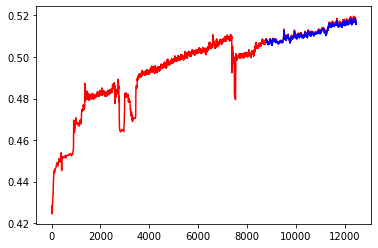

In [35]:
plt.plot(dataset, color = 'red', label = "Real CPRAVG")
plt.plot(predicted_CPRAVG_plot, color = 'blue', label = 'Predicted CPRAVG')